In [1]:
using Agents, Random, Distributions, InteractiveDynamics, Clustering, OpenStreetMapXPlot, Plots, Distances, DataStructures, LinearAlgebra;
using DataFrames, Parquet
gr()

┌ Info: Precompiling Parquet [626c502c-15b0-58ad-a749-f091afb673ae]
└ @ Base loading.jl:1423


Plots.GRBackend()

In [2]:
struct Colet
    id::Int64
    destinatie::Tuple{Int,Int,Float64}
    volum_l::Float16
    valoare_ron::Float16
end

In [3]:
@agent Transportor OSMAgent begin
    timp_ramas_pas_anterior_s::Float16
    viteza::Int
    capacitate_l::Float16
    capacitate_consumata_l::Float16
    prob_livrare_corecta::Float16
    timpi_transfer_pachet_s::Vector{Float16}
    coada_colete_livrat::Queue{Int64}
    coada_colete_ridicat::Vector{Int64}
    id_colet_in_procesare::Int
    cost::Float64
    venit::Float64
    id_depozit::Int
    id_colet_de_livrat::Int
    id_alt_transportor::Int
    activ::Bool
end

In [4]:
@agent Depozitar OSMAgent begin
    timp_ramas_pas_anterior_s::Float16
    capacitate_l::Float16
    capacitate_consumata_l::Float16
    prob_livrare_corecta::Float16
    timpi_transfer_pachet_s::Vector{Float16}
    coada_transportori::Queue{Int64}
    coada_colete::Vector{Int64}
    cost::Float64
    venit::Float64
    activ::Bool
end

In [5]:
function cel_mai_plin_depozitar(agent, model)
    depozitari = [i for i in keys(model.depozitari)]
    idmax = [length(intersect(Set(model[d].coada_colete), Set(agent.coada_colete_ridicat))) for d in depozitari]
    idmax = findmax(idmax)[2]
    return depozitari[idmax]
end

cel_mai_plin_depozitar (generic function with 1 method)

In [6]:
function cel_mai_apropiat_colet(agent, model)
    model.coordona
end

cel_mai_apropiat_colet (generic function with 1 method)

In [7]:
#agent_sz(agent) = typeof(agent) == Colet ? 0 : 5
agent_color(agent) = typeof(agent) == Depozitar ? :black : :green

function plotagents(model)
    ids = model.scheduler(model)
    ids = [i for i in ids if typeof(model[i]) != Colet]
    colors = [agent_color(model[i]) for i in ids]
    #sizes = [agent_sz(model[i]) for i in ids]
    markers = :circle
    pos = [OSM.map_coordinates(model[i], model) for i in ids]

    scatter!(
        pos;
        markercolor = colors,
        markersize = 5,
        markershapes = markers,
        label = "",
        markerstrokewidth = 0.5,
        markerstrokecolor = :black,
        markeralpha = 0.7,
    )
end

function plotpaths(model)
    ids = model.scheduler(model)
    ids = [i for i in ids if typeof(model[i]) != Colet]
    colors = [agent_color(model[i]) for i in ids]
    #sizes = [agent_sz(model[i]) for i in ids]
    markers = :circle
    pos = [OSM.map_coordinates(model[i], model) for i in ids]

    scatter!(
        pos;
        markercolor = colors,
        markersize = 5,
        markershapes = markers,
        label = "",
        markerstrokewidth = 0.5,
        markerstrokecolor = :black,
        markeralpha = 0.7,
    )
end

plotpaths (generic function with 1 method)

In [8]:
function optimize_kmedoids_closest!(model)
    sz = length(model.colete)
    destinatii = zeros(Float64, sz, 2)
    for (i, v) in enumerate(values(model.colete))
        destinatii[i, :] .= OSM.latlon(v.destinatie, model)
    end
    destinatii = transpose(destinatii)
    R = pairwise(Euclidean(), destinatii, dims=2)
    res = kmedoids(R, length(model.transportori))
    centroid_mapping = Dict{Int, Vector{Int}}(i=> Vector{Int}() for i in res.medoids)
    for i in 1:sz
        push!(centroid_mapping[res.medoids[res.assignments[i]]], i)
    end
    
    medoid_asociat = Dict()
    destinatie_asociata = Dict()
    for id in model.transportori
        distanta = reshape([i for i in OSM.latlon(model[id].pos, model)], 2, 1)
        indecsi_disponibili = (x->collect.(x)).(setdiff(keys(centroid_mapping), keys(medoid_asociat)))
        index_ales = sample(indecsi_disponibili)[1]
        idx = argmin(pairwise(Euclidean(), destinatii[:, centroid_mapping[index_ales]], distanta, dims=2))[1]
        medoid_asociat[index_ales] = id
        destinatie_asociata[id] = idx
    end

    for k in keys(centroid_mapping)
        next = destinatie_asociata[medoid_asociat[k]]
        vals = copy(centroid_mapping[k])
        closest = zeros(Int64, length(vals))
        for i in 1:(length(centroid_mapping[k]) - 1)
            idx = argmin(R[next, vals])
            closest[i] = vals[idx]
            vals = deleteat!(vals, idx)
        end
        closest[length(closest)] = vals[1]
        centroid_mapping[k] = copy(closest)
    end
    it = 1
    for id in model.transportori
        model[id].coada_colete_ridicat = [999 + v for v in centroid_mapping[res.medoids[it]]]
        it += 1
    end
end

optimize_kmedoids_closest! (generic function with 1 method)

In [9]:
function optimize_kmedoids!(model)
    sz = length(model.colete)
    destinatii = zeros(Float64, sz, 2)
    for (i, v) in enumerate(values(model.colete))
        destinatii[i, :] .= OSM.latlon(v.destinatie, model)
    end
    destinatii = transpose(destinatii)
    R = pairwise(Euclidean(), destinatii, dims=2)
    res = kmedoids(R, length(model.transportori))
    centroid_mapping = Dict{Int, Vector{Int}}(i=> Vector{Int}() for i in res.medoids)
    for i in 1:sz
        push!(centroid_mapping[res.medoids[res.assignments[i]]], i)
    end

    for k in keys(centroid_mapping)
        new_order = sortperm(R[k, centroid_mapping[k]])
        centroid_mapping[k] = centroid_mapping[k][new_order]
    end
    it = 1
    for id in model.transportori
        model[id].coada_colete_ridicat = [999 + v for v in centroid_mapping[res.medoids[it]]]
        it += 1
    end
end

optimize_kmedoids! (generic function with 1 method)

In [10]:
norm_latlon(lat::Float64, lon::Float64, bounds=model.map_bounds) = [(lat - bounds.min_y)/(bounds.max_y - bounds.min_y), (lon - bounds.min_x)/(bounds.max_x - bounds.min_x)]
denorm_latlon(lat::Float64, lon::Float64, bounds=model.map_bounds) = [lat * (bounds.max_y - bounds.min_y) + bounds.min_y, lon * (bounds.max_x - bounds.min_x) + bounds.min_x]

denorm_latlon (generic function with 2 methods)

In [11]:
function episode_end(model, step_number)
    length(model.agents) == 0
end
function  model_step!(model)
    model.timp_trecut_s += model.dim_pas_s
end

model_step! (generic function with 1 method)

In [12]:
function initialise(; map_path::String= "map.osm", n_depozitari::Int=2, n_transportori::Int=3, n_colete::Int=100, lungime_pas_s::Int=30, rng_seed=false, debug=false)
    if typeof(rng_seed) != Bool
        Random.seed!(rng_seed)
    end
    mp = OpenStreetMapSpace(map_path)
    properties = Dict()
    properties[:colete] = Dict{Int64, Colet}()
    properties[:colete_coordonate] = zeros(Float64, (n_colete, 2))
    properties[:map_coordonate_colete] = Dict{Int64, Int64}()
    properties[:map_bounds] = mp.m.bounds
    properties[:depozitari] = Dict{Int64, Tuple{Int,Int,Float64}}()
    properties[:transportori] = Vector{Int}()
    properties[:profit] = Dict{Int64, Float64}()
    properties[:timp_trecut_s] = 0
    properties[:dim_pas_s] = lungime_pas_s
    properties[:debug] = debug
    
    model = ABM(Union{Transportor, Depozitar}, mp; properties=properties)
    d_prob_livrare_corecta = truncated(Normal(.8, 2), .4, 1.)
    d_capacitate = truncated(Normal(20, 10), 5, 100)
    d_timpi_transfer = truncated(Exponential(60), 5, 60*15)
    d_viteza = truncated(Normal(10, 5), 2, 25)
    puncte_pornire = Vector{Tuple{Int,Int,Float64}}()
    # Deppzitari
    for id in 1:n_depozitari
        adresa = OSM.random_position(model)
        push!(puncte_pornire, adresa)
        ruta = OSM.plan_route(adresa, adresa, model)
        capacitate = rand(d_capacitate)
        prob_livrare = rand(d_prob_livrare_corecta)
        timp_transfer = rand(d_timpi_transfer, 1)
        depozitar = Depozitar(id, adresa, ruta, adresa, 0, capacitate, 0., prob_livrare,
            timp_transfer, Queue{Int64}(), [], 0, 0, true)
        add_agent_pos!(depozitar, model)
        model.depozitari[id] = adresa
    end
    # Colete
    d_volum = truncated(Normal(.1, .1), .01, 2)
    d_valoare = truncated(Normal(50, 50), 5, 10000)
    id_depozitari = collect(1:n_depozitari)
    for (i, id) in enumerate(1000:(1000 + n_colete - 1))
        sfarsit = OSM.random_road_position(model)
        volum = rand(d_volum)
        oid = sample(id_depozitari)
        model[oid].capacitate_consumata_l += volum
        valoare = rand(d_valoare)
        colet = Colet(id, sfarsit, volum, valoare)
        model.properties[:colete][id] = colet
        model.properties[:colete_coordonate][i, :] .= norm_latlon(OSM.latlon(sfarsit, model)..., model.map_bounds)
        model.properties[:map_coordonate_colete][i] = id
        push!(model[oid].coada_colete, id)
    end
    
    # Transportori
    d_capacitate = truncated(Normal(5, 2), 1, 20)
    it = 1
    for id in (n_depozitari+1):(n_depozitari + n_transportori)
        inceput = OSM.random_road_position(model)
        ruta = []
        colete_de_ridicat = []
        colete_de_livrat = Queue{Int}()
        capacitate = rand(d_capacitate)
        prob_livrare = rand(d_prob_livrare_corecta)
        timp_transfer = rand(d_timpi_transfer, 1)
        viteza = trunc(Int, rand(d_viteza, 1)[1])
        transportor = Transportor(id, inceput, ruta, inceput, 0, viteza, capacitate, 0., 
            prob_livrare, timp_transfer, colete_de_livrat, colete_de_ridicat, -1, 0, 0, -1, 0, -1, true)
        add_agent_pos!(transportor, model)
        push!(model.transportori, id)
        it += 1
    end
    return model
end

initialise (generic function with 1 method)

#### Politici:

 * Mergi la cel mai valoros pachet
 * Mergi la cel mai apropiat depozitar si ia cat poti in functie de valoare
 * Pastreaza directia de mers si ia pachete de la toti cei de pe ruta care au pachete ce merg inspre destinatie
 * Mergi la cel mai apropiat depozitar si ia cate pachhete poti pentru a le livra la cel mai apropiat centru k-means (k=nr transportori)

In [13]:
function agent_step!(agent, model)
    # Step every 30 seconds
    step_time_s = model.dim_pas_s
    debug = model.debug
    timp_tr_mediu = mean(agent.timpi_transfer_pachet_s)
    d_timpi_transfer = truncated(Exponential(timp_tr_mediu), 5, 60*15)
    if (typeof(agent) == Depozitar)
        if length(agent.coada_colete) == 0
            model.profit[agent.id] = agent.venit - agent.cost
            delete!(model.depozitari, agent.id)
            kill_agent!(agent.id, model)
        end
        agent.timp_ramas_pas_anterior_s = (length(agent.coada_transportori) == 0) ? 0 : agent.timp_ramas_pas_anterior_s
        step_time_s -= agent.timp_ramas_pas_anterior_s
        while (length(agent.coada_transportori) > 0) & (step_time_s > 0)
            timp_incarcare = rand(d_timpi_transfer)[1]
            push!(agent.timpi_transfer_pachet_s, timp_incarcare)
            step_time_s = step_time_s - timp_incarcare
            agent.timp_ramas_pas_anterior_s = -step_time_s
            tr = dequeue!(agent.coada_transportori)
            colete = intersect(agent.coada_colete, model[tr].coada_colete_ridicat)
            debug && println("Depozitar $(agent.id) incarc transportorul $tr cu coletele $colete")
            agent.venit += sum([model.colete[i].valoare_ron*.005 for i in colete])
            agent.cost += sum([model.colete[i].volum_l*.002 for i in colete]) + 22/3600*step_time_s
            foreach(i -> enqueue!(model[tr].coada_colete_livrat, i), colete)
            model[tr].id_depozit = -1
            setdiff!(agent.coada_colete, colete)
            setdiff!(model[tr].coada_colete_ridicat, colete)
        end
    elseif typeof(agent) == Transportor
        agent.timp_ramas_pas_anterior_s = max(agent.timp_ramas_pas_anterior_s - step_time_s, 0)
        ans = is_stationary(agent, model) ? "da" : "nu"
        #debug && println("Transportor $(agent.id): Timp anterior ramas - $(agent.timp_ramas_pas_anterior_s), stau pe loc $ans")
        
        if agent.timp_ramas_pas_anterior_s <= 0 && is_stationary(agent, model)
            debug && println("Transportor $(agent.id): Timp anterior ramas - $(agent.timp_ramas_pas_anterior_s), stau pe loc? $ans")
            # S-a ajuns la destinatie si se livreaza pachetul 
            if (agent.id_colet_de_livrat>0)
                timp_incarcare = rand(d_timpi_transfer)[1]
                push!(agent.timpi_transfer_pachet_s, timp_incarcare)
                agent.timp_ramas_pas_anterior_s = timp_incarcare
                agent.venit += model.colete[agent.id_colet_de_livrat].valoare_ron*.01
                delete!(model.colete, agent.id_colet_de_livrat)
                debug && println("Transportor $(agent.id): Am livrat $(agent.id_colet_de_livrat).")
                agent.id_colet_de_livrat = 0
            end
            # Am pachete la mine si trebuie sa-l livrez pe urmatorul
            if (length(agent.coada_colete_livrat) > 0) && (agent.id_colet_de_livrat==0)
                agent.id_colet_de_livrat = dequeue!(agent.coada_colete_livrat)
                debug && println("Transportor $(agent.id): Livrez $(agent.id_colet_de_livrat)")
                agent.destination = model.colete[agent.id_colet_de_livrat].destinatie
                agent.route = OSM.plan_route(agent.pos, agent.destination, model)
            end
            # Nu mai am colete si trebuie sa merg la un depozit sa iau
            if ((length(agent.coada_colete_livrat)==0) && (length(agent.coada_colete_ridicat) > 0)) && (agent.id_colet_de_livrat<=0)
                agent.id_depozit = cel_mai_plin_depozitar(agent, model)
                debug && println("Transportor $(agent.id): Iau pachete de la $(agent.id_depozit).")
                agent.destination = model.depozitari[agent.id_depozit]
                agent.route = OSM.plan_route(agent.pos, agent.destination, model)
                agent.id_colet_de_livrat = -1
            end
            # Sunt la depozit si trebuie sa stau la coada ca sa fiu incarcat cu colete
            if (length(setdiff([agent.id_depozit], nearby_ids(agent.pos, model, 10))) == 0) && (agent.id_colet_de_livrat == -1)
                enqueue!(model[agent.id_depozit].coada_transportori, agent.id)
                agent.id_colet_de_livrat = 0
            end
            # Nu mai am treaba si ma retrag
            if ((length(agent.coada_colete_ridicat) == 0) && (length(agent.coada_colete_livrat)==0)) && (agent.id_colet_de_livrat==0)
                model.profit[agent.id] = agent.venit - agent.cost
                delete!(model.colete, agent.id_colet_de_livrat)
                kill_agent!(agent.id, model)
            end
        end
        distanta_parcursa = step_time_s * agent.viteza
        agent.cost += distanta_parcursa * 7/100_000 * 6 + 22/3600*(step_time_s)
        move_along_route!(agent, model, distanta_parcursa)
    end
end


agent_step! (generic function with 1 method)

In [105]:
@time begin
    n_depozitari=3
    n_transportori=6
    n_colete=100
    lungime_pas_s = 10
    rng_seed = 42#12
    m1 = initialise(;n_depozitari=n_depozitari, n_transportori=n_transportori, n_colete=n_colete,
        lungime_pas_s=lungime_pas_s, rng_seed=rng_seed)#, debug=true)
    m2 = initialise(;n_depozitari=n_depozitari, n_transportori=n_transportori, n_colete=n_colete,
        lungime_pas_s=lungime_pas_s, rng_seed=rng_seed)#, debug=true)
end

  0.587799 seconds (3.69 M allocations: 271.672 MiB, 8.70% gc time)


┌ Warning: AgentType is not concrete. If your agent is parametrically typed, you're probably seeing this warning because you gave `Agent` instead of `Agent{Float64}` (for example) to this function. You can also create an instance of your agent and pass it to this function. If you want to use `Union` types for mixed agent models, you can silence this warning.
└ @ Agents /home/drakop/.julia/packages/Agents/h9Ls1/src/core/model.jl:297
┌ Warning: AgentType is not concrete. If your agent is parametrically typed, you're probably seeing this warning because you gave `Agent` instead of `Agent{Float64}` (for example) to this function. You can also create an instance of your agent and pass it to this function. If you want to use `Union` types for mixed agent models, you can silence this warning.
└ @ Agents /home/drakop/.julia/packages/Agents/h9Ls1/src/core/model.jl:297


AgentBasedModel with 9 agents of type Union{Depozitar, Transportor}
 space: OpenStreetMapSpace with 484 roadways and 775 intersections
 scheduler: fastest
 properties: colete_coordonate, map_coordonate_colete, debug, transportori, colete, depozitari, profit, dim_pas_s, map_bounds, timp_trecut_s

In [106]:
function model_data(model)
    avg_profit(model) = mean(values(model.profit))
    [:timp_trecut_s, avg_profit]
end

model_data (generic function with 1 method)

In [107]:
a = m1[6]

Transportor(6, (239, 206, 430.1795905080482), Int64[], (239, 206, 430.1795905080482), Float16(0.0), 10, Float16(5.957), Float16(0.0), Float16(0.8945), Float16[128.0], Queue{Int64}(Deque [Int64[]]), Int64[], -1, 0.0, 0.0, -1, 0, -1, true)

In [108]:
optimize_kmedoids_closest!(m1)

In [109]:
adf, mdf = run!(m1, agent_step!, model_step!, episode_end; mdata=model_data, adata=[:pos, :destination, :venit, :cost])
mean(values(m1.profit))

-25.961034181740576

In [110]:
write_parquet("model_data.pq", mdf)

4

In [111]:
adf[!, :agent_type] = map(String, adf[!, :agent_type])
adf.pos_lat = map(x->norm_latlon(OSM.latlon(x, m1)..., m1.map_bounds)[1], adf.pos)
adf.pos_lon = map(x->norm_latlon(OSM.latlon(x, m1)..., m1.map_bounds)[2], adf.pos)
adf.dest_lat = map(x->norm_latlon(OSM.latlon(x, m1)..., m1.map_bounds)[1], adf.destination)
adf.dest_lon = map(x->norm_latlon(OSM.latlon(x, m1)..., m1.map_bounds)[2], adf.destination)
select!(adf, Not([:pos, :destination]))

,step,id,agent_type,venit,cost,pos_lat,pos_lon,dest_lat,dest_lon
,Int64,Int64,String,Float64,Float64,Float64,Float64,Float64,Float64
1,0,1,Depozitar,0.0,0.0,0.616571,0.448665,0.616571,0.448665
2,0,2,Depozitar,0.0,0.0,0.612286,0.668073,0.612286,0.668073
3,0,3,Depozitar,0.0,0.0,0.333543,0.444601,0.333543,0.444601
4,0,4,Transportor,0.0,0.0,0.551986,0.730652,0.551986,0.730652
5,0,5,Transportor,0.0,0.0,0.897287,0.453773,0.897287,0.453773
6,0,6,Transportor,0.0,0.0,0.040531,0.444336,0.040531,0.444336
7,0,7,Transportor,0.0,0.0,0.651826,0.661808,0.651826,0.661808
8,0,8,Transportor,0.0,0.0,0.683031,0.449988,0.683031,0.449988
9,0,9,Transportor,0.0,0.0,0.903584,0.904479,0.903584,0.904479


In [112]:
write_parquet("agent_data.pq", adf)

4

In [ ]:
optimize_kmedoids!(m2)

In [ ]:
run!(m2, agent_step!, model_step!, episode_end)
mean(values(m2.profit))

In [ ]:
m1_means = Vector{Float16}()
m2_means = Vector{Float16}()
for i in 1:100
    m1 = initialise(;n_depozitari=n_depozitari, n_transportori=n_transportori, n_colete=n_colete,
        lungime_pas_s=lungime_pas_s, rng_seed=i)#, debug=true)
    optimize_kmedoids_closest!(m1)
    run!(m1, agent_step!, model_step!, episode_end)
    push!(m1_means, mean(values(m1.profit)))
    m2 = initialise(;n_depozitari=n_depozitari, n_transportori=n_transportori, n_colete=n_colete,
        lungime_pas_s=lungime_pas_s, rng_seed=i)
    optimize_kmedoids!(m2)
    run!(m2, agent_step!, model_step!, episode_end)
    push!(m2_means, mean(values(m2.profit)))
end

In [25]:
mean(m1_means)

Float16(-31.48)

In [26]:
mean(m2_means)

NaN16

In [18]:
@time begin
    n_depozitari=3
    n_transportori=6
    n_colete=1000
    lungime_pas_s = 1
    m = initialise(;n_depozitari=n_depozitari, n_transportori=n_transportori, n_colete=n_colete, lungime_pas_s=lungime_pas_s)
end

  0.377622 seconds (1.89 M allocations: 154.075 MiB, 18.91% gc time)


┌ Warning: AgentType is not concrete. If your agent is parametrically typed, you're probably seeing this warning because you gave `Agent` instead of `Agent{Float64}` (for example) to this function. You can also create an instance of your agent and pass it to this function. If you want to use `Union` types for mixed agent models, you can silence this warning.
└ @ Agents /home/drakop/.julia/packages/Agents/h9Ls1/src/core/model.jl:297


AgentBasedModel with 9 agents of type Union{Depozitar, Transportor}
 space: OpenStreetMapSpace with 484 roadways and 775 intersections
 scheduler: fastest
 properties: debug, colete, depozitari, profit, dim_pas_s, timp_trecut_s

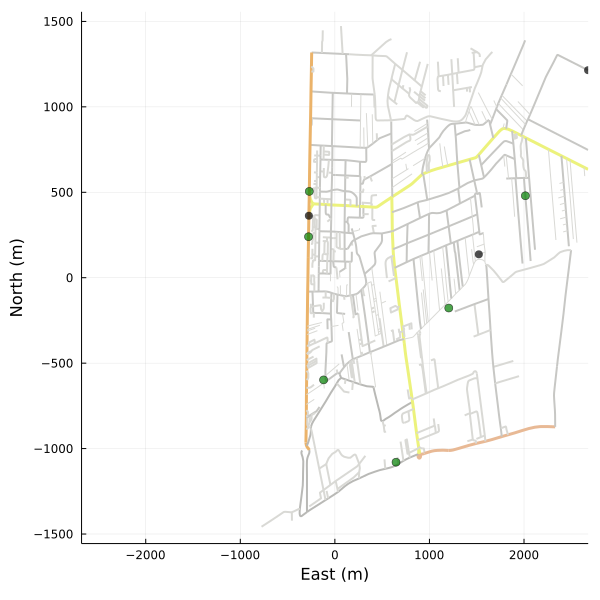

In [19]:
plotmap(m.space.m)
plotagents(m)

In [20]:
a, b = run!(m, agent_step!, model_step!, episode_end)

(0×0 DataFrame, 0×0 DataFrame)

In [21]:
m.profit

Dict{Int64, Float64} with 9 entries:
  5 => -641.533
  4 => -673.44
  6 => -240.745
  7 => -56.4673
  2 => 109.755
  9 => -190.483
  8 => -105.181
  3 => 121.369
  1 => 115.487

In [22]:
mean(values(m.profit))

-173.4710847082195

In [23]:
median(values(m.profit))

-105.18132482648491